In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import preprocessing
import algorithms
import plots

In [2]:
DATA_PATH_1 = Path("../data/data2.mat")
DATA_PATH_2 = Path("../data/bird_small.png")
DATA_PATH_3 = Path("../data/data1.mat")
DATA_PATH_4 = Path("../data/faces.mat")

# Part 1

## K-means Clustering
In this this exercise, you will implement the K-means algorithm and use it
for image compression. You will first start on an example 2D dataset that
will help you gain an intuition of how the K-means algorithm works. After
that, you wil use the K-means algorithm for image compression by reducing
the number of colors that occur in an image to only those that are most
common in that image. You will be using ex7.m for this part of the exercise.

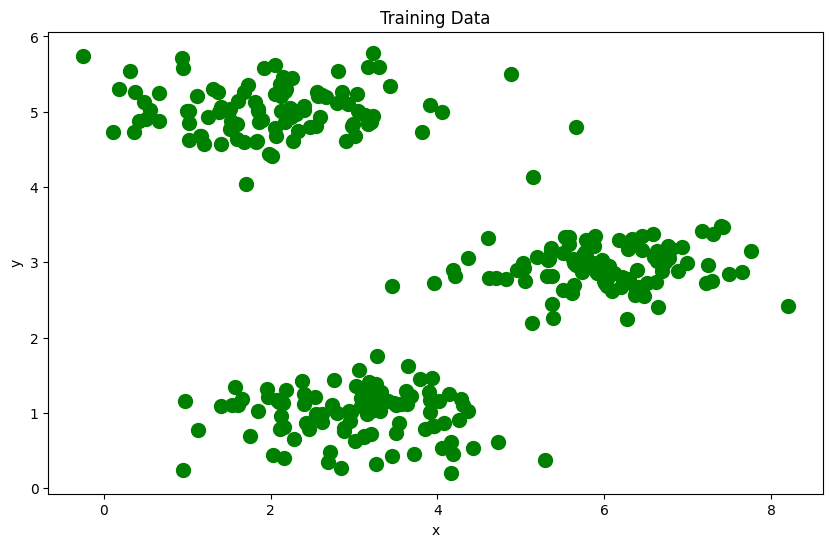

In [3]:
data = preprocessing.read_data(DATA_PATH_1)
x = data[0]
plots.scatter(x[:, 0], x[:, 1])

## Implementing K-means
The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, you are given a training set $\{x^{(1)} , ..., x^{(m)} \}$ (where $x^{(i)} \in R^n$ ), and want to group the data into a few cohesive “clusters”. The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

```
% Initialize centroids
centroids = kMeansInitCentroids(X, K);
for iter = 1:iterations
% Cluster assignment step: Assign each data point to the
% closest centroid. idx(i) corresponds to cˆ(i), the index
% of the centroid assigned to example i
idx = findClosestCentroids(X, centroids);
% Move centroid step: Compute means based on centroid
% assignments
centroids = computeMeans(X, idx, K);
end
```

The inner-loop of the algorithm repeatedly carries out two steps: (i) Assigning each training example x(i) to its closest centroid, and (ii) Recomputing the mean of each centroid using the points assigned to it. The K-means algorithm will always converge to some final set of means for the centroids.

Note that the converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion). You will implement the two phases of the K-means algorithm separately in the next sections.

### Finding closest centroids
In the “cluster assignment” phase of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids. Specifically, for every example i we set

$$c^{(i)} := j$$

that minimizes $||x^{(i)} − \mu_j ||^2$ ,

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the j’th centroid. Note that c(i) corresponds to idx(i) in the starter code.

Your task is to complete the code in findClosestCentroids.m. This function takes the data matrix X and the locations of all centroids inside centroids and should output a one-dimensional array idx that holds the index (a value in $\{1, ..., K\}$, where K is total number of centroids) of the closest centroid to every training example.

You can implement this using a loop over every training example and every centroid.
Once you have completed the code in findClosestCentroids.m, the script ex7.m will run your code and you should see the output $[1 3 2]$ corresponding to the centroid assignments for the first 3 examples.

### Computing centroid means
Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid k we set

$$\mu_k := \frac{1}{|C_k|}\sum_{i \in C_k}x^{(i)}$$

where $C_k$ is the set of examples that are assigned to centroid k. Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid k = 2, then you should update $\mu_2 = \frac{1}{2}(x^{(3)} + x^{(5)} )$.

You should now complete the code in computeCentroids.m. You can implement this function using a loop over the centroids. You can also use a loop over the examples; but if you can use a vectorized implementation that does not use such a loop, your code may run faster.

## K-means on example dataset
After you have completed the two functions (findClosestCentroids and computeCentroids), the next step in ex7.m will run the K-means algorithm on a toy 2D dataset to help you understand how K-means works. Your functions are called from inside the runKmeans.m script. We encourage you to take a look at the function to understand how it works. Notice that the code calls the two functions you implemented in a loop.

In [4]:
k = 3
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
model = algorithms.KMeansRegression(k)
model.fit(x, initial_centroids=initial_centroids)
# expected (2, 5), (3, 1), (6, 3)
centroids = model.centroids_history[-1]
print(centroids)

[[1.95399466 5.02557006]
 [3.04367119 1.01541041]
 [6.03366736 3.00052511]]


## Visualization

When you run the next step, the K-means code will produce a visualization that steps you through the progress of the algorithm at each iteration. Press enter multiple times to see how each step of the K-means algorithm changes the centroids and cluster assignments. 

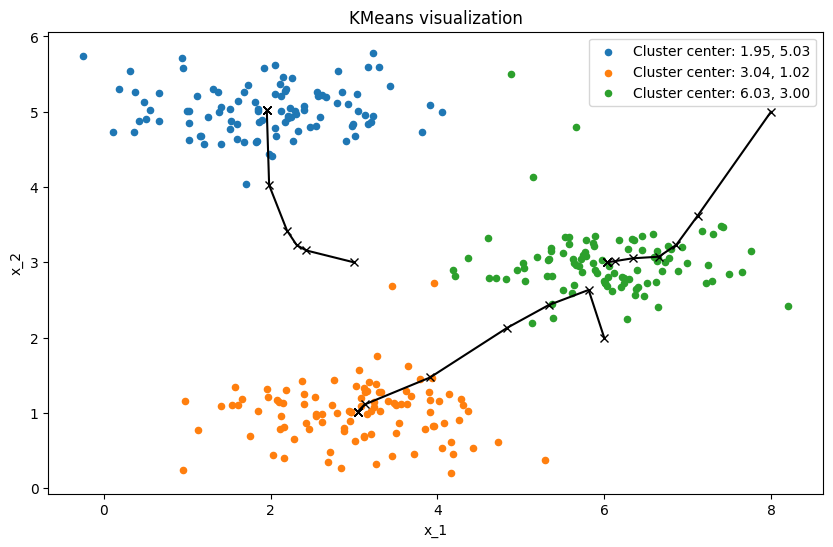

In [5]:
plots.visualize_k_means(x, model)

# Part 2

## Image compression with K-means
In this exercise, you will apply K-means to image compression. In a straightforward 24-bit color representation of an image,2 each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors.

By making this reduction, it is possible to represent (compress) the photo in an efficient way. Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

In [6]:
x, original_shape = preprocessing.read_image(DATA_PATH_2)
k = 16
model = algorithms.KMeansRegression(k)
model.fit(x)

# expected 16 x 3
final_colors = model.centroids_history[-1]
print(final_colors.shape)

(16, 3)


## Reconstructing compressed image
Finally, you can view the effects of the compression by reconstructing the image based only on the centroid assignments. Specifically, you can replace each pixel location with the mean of the centroid assigned to it. Even though the resulting image retains most of the characteristics of the original, we also see some compression artifacts

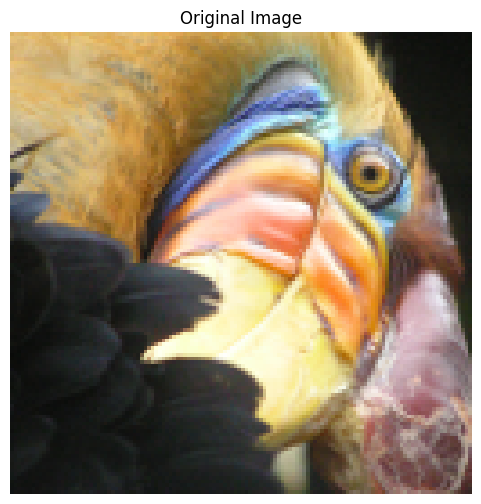

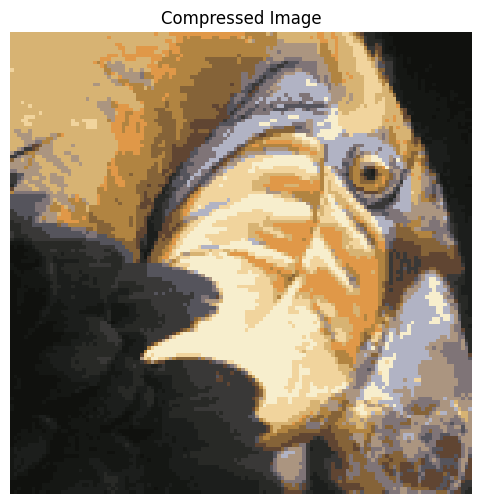

In [7]:
from PIL import Image

original_image = Image.open(DATA_PATH_2)
plots.plot_image(original_image, "Original Image")

compressed_image = algorithms.reconstruct_image(model, x, original_shape)
plots.plot_image(compressed_image, "Compressed Image")

# Part 3

## Example Dataset
To help you understand how PCA works, you will first start with a 2D dataset which has one direction of large variation and one of smaller variation. The script ex7 pca.m will plot the training data (Figure 4). In this part of the exercise, you will visualize what happens when you use PCA to reduce the data from 2D to 1D. In practice, you might want to reduce data from 256 to 50 dimensions, say; but using lower dimensional data in this example allows us to visualize the algorithms better.

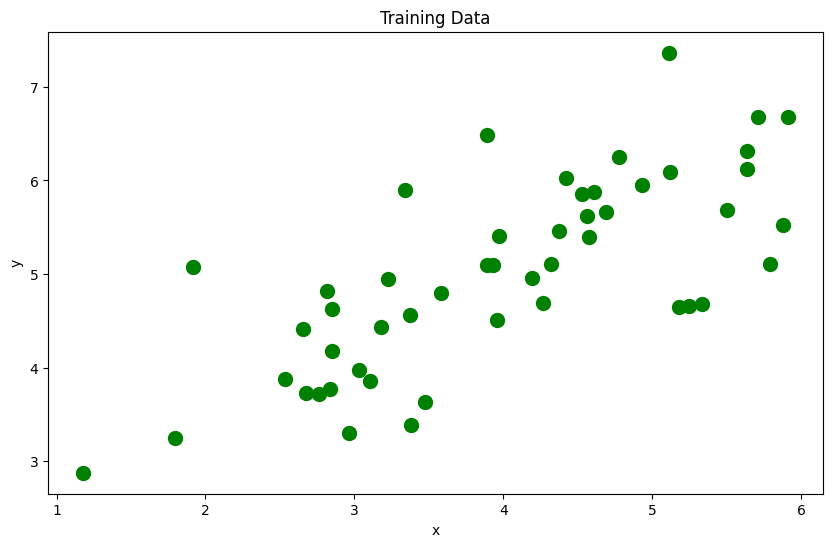

In [8]:
data = preprocessing.read_data(DATA_PATH_3)
x = data[0]
plots.scatter(x[:, 0], x[:, 1])

## Implementing PCA
In this part of the exercise, you will implement PCA. PCA consists of two computational steps: First, you compute the covariance matrix of the data.

Then, you use Octave/MATLAB’s SVD function to compute the eigenvectors $U_1 , U_2 , . . . , U_n $. These will correspond to the principal components of variation in the data.
Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range. In the provided script ex7 pca.m, this normalization has been performed for you using the featureNormalize function.

After normalizing the data, you can run PCA to compute the principal components. You task is to complete the code in pca.m to compute the principal components of the dataset. First, you should compute the covariance matrix of the data, which is given by:

$$\sum = \frac{1}{m}X^TX$$

where X is the data matrix with examples in rows, and m is the number of examples. Note that $\sum$ is a $n × n$ matrix and not the summation operator.

After computing the covariance matrix, you can run SVD on it to compute the principal components. In Octave/MATLAB, you can run SVD with the following command: $[U, S, V] = svd(Sigma)$, where U will contain the principal components and S will contain a diagonal matrix.

Once you have completed pca.m, the ex7 pca.m script will run PCA on the example dataset and plot the corresponding principal components found. The script will also output the top principal component (eigen- vector) found, and you should expect to see an output of about $[-0.707 -0.707]$.

In [9]:
normalizer = preprocessing.FeatureNormalizer(x)
x_norm = normalizer.normalize(x)
k = 1
model = algorithms.PcaRegression(k)
model.fit(x_norm)
# expected -0.707, -0.707
print(model.u)

[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]


## Dimensionality Reduction with PCA
After computing the principal components, you can use them to reduce the feature dimension of your dataset by projecting each example onto a lower dimensional space, $x^{(i)} \to z^{(i)}$ (e.g., projecting the data from 2D to 1D). In this part of the exercise, you will use the eigenvectors returned by PCA and project the example dataset into a 1-dimensional space.

In practice, if you were using a learning algorithm such as linear regression or perhaps neural networks, you could now use the projected data instead of the original data. By using the projected data, you can train your model faster as there are less dimensions in the input.

### Projecting the data onto the principal components
You should now complete the code in projectData.m. Specifically, you are given a dataset X, the principal components U, and the desired number of dimensions to reduce to K. You should project each example in X onto the top K components in U. Note that the top K components in U are given by the first K columns of U, that is $U_reduce = U(:, 1:K)$.
Once you have completed the code in projectData.m, ex7 pca.m will project the first example onto the first dimension and you should see a value of about 1.481 (or possibly -1.481, if you got $−U_1$ instead of $U_1$ ).



In [10]:
# expected 1.481
print(model.z[0])

[1.49631261]


### Reconstructing an approximation of the data
After projecting the data onto the lower dimensional space, you can approximately recover the data by projecting them back onto the original high dimensional space. Your task is to complete recoverData.m to project each example in Z back onto the original space and return the recovered approximation in X rec.

Once you have completed the code in recoverData.m, ex7 pca.m will recover an approximation of the first example and you should see a value of about $[-1.047 -1.047]$.

In [11]:
# expected −1.047, −1.047
x_rec = model.recover_data()
print(x_rec[0])

[-1.05805279 -1.05805279]



## Visualizing the projections
After completing both projectData and recoverData, ex7 pca.m will now perform both the projection and approximate reconstruction to show how the projection affects the data. In Figure 6, the original data points are indicated with the blue circles, while the projected data points are indicated with the red circles. The projection effectively only retains the information in the direction given by $U_1$.

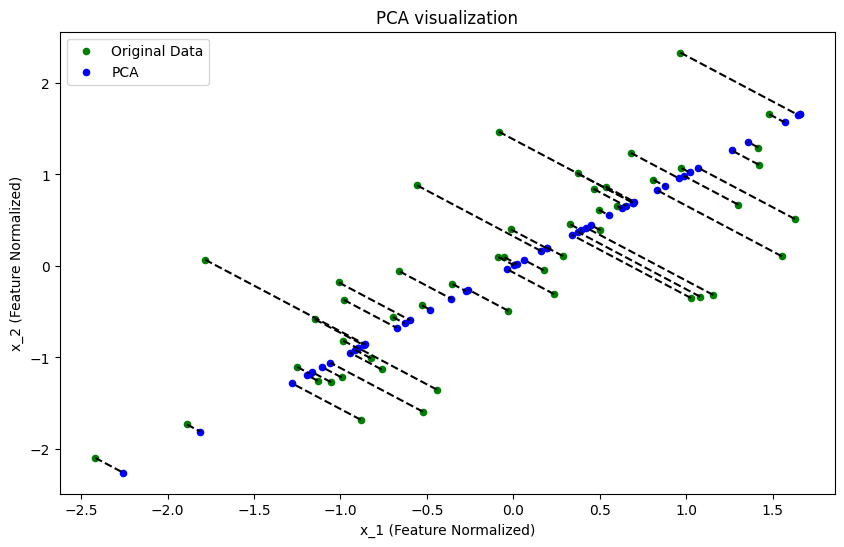

In [12]:
plots.visualize_pca(x_norm, x_rec)

# Part 4

## Face Image Dataset
In this part of the exercise, you will run PCA on face images to see how it can be used in practice for dimension reduction. The dataset ex7faces.mat contains a dataset3 X of face images, each $32 × 32$ in grayscale. Each row of X corresponds to one face image (a row vector of length 1024). The next step in ex7 pca.m will load and visualize the first 100 of these face images.

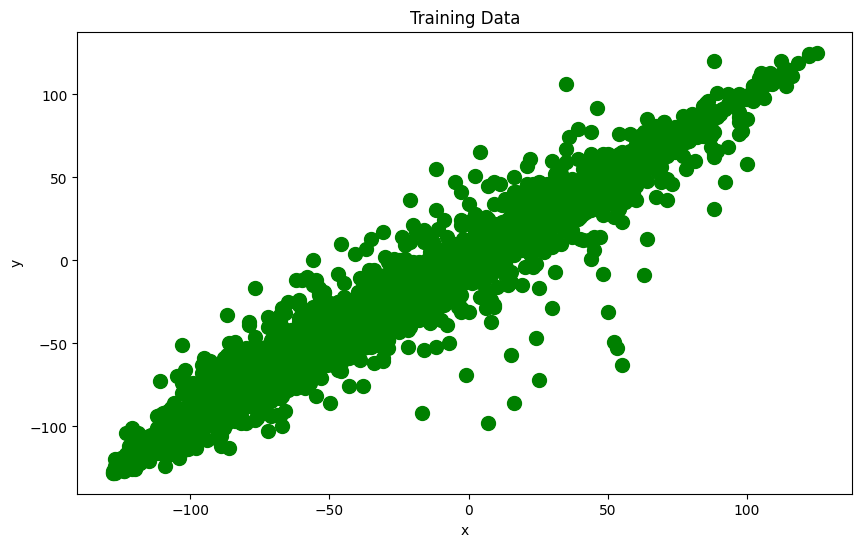

In [13]:
data = preprocessing.read_data(DATA_PATH_4)
x = data[0]
plots.scatter(x[:, 0], x[:, 1])

### PCA on Faces
To run PCA on the face dataset, we first normalize the dataset by subtracting the mean of each feature from the data matrix X. The script ex7 pca.m will do this for you and then run your PCA code. After running PCA, you will obtain the principal components of the dataset. Notice that each principal component in U (each row) is a vector of length n (where for the face dataset, $n = 1024$). It turns out that we can visualize these principal components by reshaping each of them into a $32 × 32$ matrix that corresponds to the pixels in the original dataset. The script ex7 pca.m displays the first 36 principal components that describe the largest variations. If you want, you can also change the code to display more principal components to see how they capture more and more details.

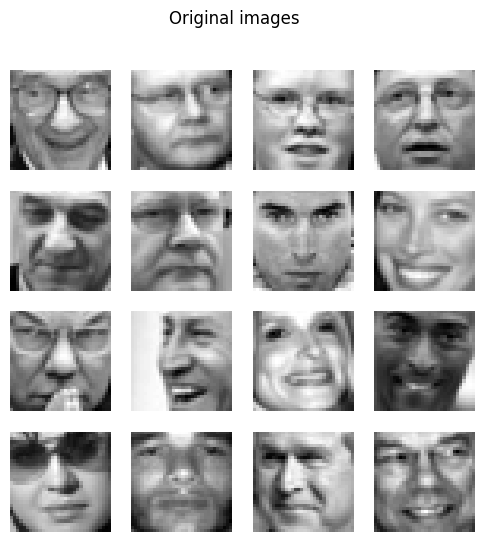

In [14]:
plots.display_image_grid(x, title="Original images")

### Dimensionality Reduction
Now that you have computed the principal components for the face dataset, you can use it to reduce the dimension of the face dataset. This allows you to use your learning algorithm with a smaller input size (e.g., 100 dimensions) instead of the original 1024 dimensions. This can help speed up your learning algorithm.

The next part in ex7 pca.m will project the face dataset onto only the first 100 principal components. Concretely, each face image is now described by a vector $z^{(i)} \in R^{100}$.

To understand what is lost in the dimension reduction, you can recover the data using only the projected dataset. In ex7 pca.m, an approximate recovery of the data is performed and the original and projected face images are displayed side by side. From the reconstruction, you can observe that the general structure and appearance of the face are kept while the fine details are lost. This is a remarkable reduction (more than 10×) in the dataset size that can help speed up your learning algorithm significantly.

For example, if you were training a neural network to perform person recognition (gven a face image, predict the identitfy of the person), you can use the dimension reduced input of only a 100 dimensions instead of the original pixels.

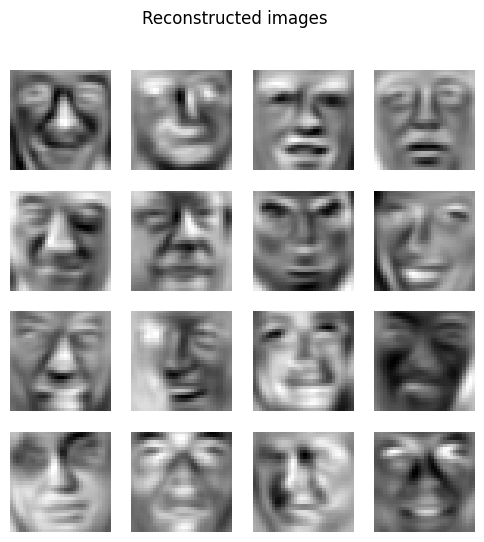

In [15]:
normalizer = preprocessing.FeatureNormalizer(x)
k = 100
model = algorithms.PcaRegression(k)
model.fit(normalizer.normalize(x))
x_rec = model.recover_data()
plots.display_image_grid(x_rec, title="Reconstructed images")